In [1]:
# importing Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings as wr
import re
import nltk

import pyLDAvis.gensim_models as gensimvis
import pyLDAvis

wr.filterwarnings('ignore')


In [3]:
!pip install gensim

In [5]:
!pip install pyLDAvis

In [7]:
!pip install wordcloud matplotlib
!pip install ipywidgets matplotlib pandas
!pip install ipywidgets
!pip install textblob


In [8]:
# loading and reading dataset
df = pd.read_csv("BA_airlinereviews.csv")
df.head(10)


,Unnamed: 0,OverallRating,ReviewHeader,Name,Datetime,VerifiedReview,ReviewBody,TypeOfTraveller,SeatType,Route,DateFlown,SeatComfort,CabinStaffService,GroundService,ValueForMoney,Recommended,Aircraft,Food&Beverages,InflightEntertainment,Wifi&Connectivity
0,0,1.0,"""Service level far worse then Ryanair""",L Keele,19th November 2023,True,4 Hours before takeoff we received a Mail stat...,Couple Leisure,Economy Class,London to Stuttgart,Nov-23,1.0,1.0,1.0,1.0,no,NaN,NaN,NaN,NaN
1,1,3.0,"""do not upgrade members based on status""",Austin Jones,19th November 2023,True,I recently had a delay on British Airways from...,Business,Economy Class,Brussels to London,Nov-23,2.0,3.0,1.0,2.0,no,A320,1.0,2.0,2.0
2,2,8.0,"""Flight was smooth and quick""",M A Collie,16th November 2023,False,"Boarded on time, but it took ages to get to th...",Couple Leisure,Business Class,London Heathrow to Dublin,Nov-23,3.0,3.0,4.0,3.0,yes,A320,4.0,NaN,NaN
3,3,1.0,"""Absolutely hopeless airline""",Nigel Dean,16th November 2023,True,"5 days before the flight, we were advised by B...",Couple Leisure,Economy Class,London to Dublin,Dec-22,3.0,3.0,1.0,1.0,no,NaN,NaN,NaN,NaN
4,4,1.0,"""Customer Service is non existent""",Gaylynne Simpson,14th November 2023,False,"We traveled to Lisbon for our dream vacation, ...",Couple Leisure,Economy Class,London to Lisbon,Nov-23,1.0,1.0,1.0,1.0,no,NaN,1.0,1.0,1.0
5,5,1.0,"""I can’t imagine a worst airline""",A Narden,12th November 2023,True,Booked a flight from Bucharest to Manchester w...,Solo Leisure,Economy Class,Bucharest to Manchester via London,Sep-23,1.0,1.0,1.0,1.0,no,A320,1.0,1.0,NaN
6,6,8.0,"""sufficient leg and arm room""",Graeme Boothman,8th November 2023,True,Booked online months ago and the only hitch wa...,Couple Leisure,Premium Economy,Manchester to Cape Town via London,Nov-23,5.0,5.0,4.0,4.0,yes,Boeing 777-300,4.0,4.0,NaN
7,7,7.0,“crew were polite”,R Vines,7th November 2023,True,The flight was on time. The crew were polite. ...,Solo Leisure,Economy Class,Seville to London Gatwick,Nov-23,3.0,3.0,3.0,3.0,yes,A320,3.0,NaN,NaN
8,8,2.0,"""Angry, disappointed, and unsatisfied""",Massimo Tricca,5th November 2023,False,"Angry, disappointed, and unsatisfied. My route...",Family Leisure,Economy Class,London Heatrow to Atlanta,Nov-23,4.0,5.0,3.0,5.0,yes,Boeing 777,4.0,4.0,3.0
9,9,3.0,"""BA now stands for Basic Airways""",J Kaye,5th November 2023,True,"As an infrequent flyer, British Airways was al...",Couple Leisure,Economy Class,Gatwick to Antalya,Oct-23,3.0,3.0,3.0,1.0,no,NaN,1.0,1.0,1.0


## Data Preparation - All Features

The following data preparation steps were performed:
1. Convert ‘Datetime’ and ‘DateFlown’ from string to datetime format.
2. Remove missing values

In [12]:
#convert ‘Datetime’ and ‘DateFlown’ from string to datetime format
df['Datetime'] = pd.to_datetime(df['Datetime'], format='%dth %B %Y', errors='coerce')
#Note: Datetime default format is YYYY-MM-DD. 

df['DateFlown'] = pd.to_datetime(df['DateFlown'], format='%B %Y', errors='coerce') 
#Note: Datetime format auto generates 01 as the day since there is no day tagged to each value. November 2023 -> 2023-11-01

df.head()

,Unnamed: 0,OverallRating,ReviewHeader,Name,Datetime,VerifiedReview,ReviewBody,TypeOfTraveller,SeatType,Route,DateFlown,SeatComfort,CabinStaffService,GroundService,ValueForMoney,Recommended,Aircraft,Food&Beverages,InflightEntertainment,Wifi&Connectivity
0,0,1.0,"""Service level far worse then Ryanair""",L Keele,2023-11-19,True,4 Hours before takeoff we received a Mail stat...,Couple Leisure,Economy Class,London to Stuttgart,NaT,1.0,1.0,1.0,1.0,no,NaN,NaN,NaN,NaN
1,1,3.0,"""do not upgrade members based on status""",Austin Jones,2023-11-19,True,I recently had a delay on British Airways from...,Business,Economy Class,Brussels to London,NaT,2.0,3.0,1.0,2.0,no,A320,1.0,2.0,2.0
2,2,8.0,"""Flight was smooth and quick""",M A Collie,2023-11-16,False,"Boarded on time, but it took ages to get to th...",Couple Leisure,Business Class,London Heathrow to Dublin,NaT,3.0,3.0,4.0,3.0,yes,A320,4.0,NaN,NaN
3,3,1.0,"""Absolutely hopeless airline""",Nigel Dean,2023-11-16,True,"5 days before the flight, we were advised by B...",Couple Leisure,Economy Class,London to Dublin,NaT,3.0,3.0,1.0,1.0,no,NaN,NaN,NaN,NaN
4,4,1.0,"""Customer Service is non existent""",Gaylynne Simpson,2023-11-14,False,"We traveled to Lisbon for our dream vacation, ...",Couple Leisure,Economy Class,London to Lisbon,NaT,1.0,1.0,1.0,1.0,no,NaN,1.0,1.0,1.0


In [14]:
# check for missing values:
df.isnull().sum()


Unnamed: 0                  0
OverallRating               5
ReviewHeader                0
Name                        0
Datetime                  757
VerifiedReview              0
ReviewBody                  0
TypeOfTraveller           771
SeatType                    2
Route                     775
DateFlown                3701
SeatComfort               116
CabinStaffService         127
GroundService             846
ValueForMoney               1
Recommended                 0
Aircraft                 1779
Food&Beverages            386
InflightEntertainment    1150
Wifi&Connectivity        3092
dtype: int64

In [16]:
#check proportion of missing values
missing_proportion = df.isnull().mean() * 100 #mean = sum of true values (1)/total number of rows
missing_proportion


#Alternative calculation

# # Calculate the total number of rows
# total_rows = len(df)

# # Calculate the proportion of missing values for each column
# missing_proportion = df.isnull().sum() / total_rows * 100

# missing_proportion

Unnamed: 0                 0.000000
OverallRating              0.135099
ReviewHeader               0.000000
Name                       0.000000
Datetime                  20.453931
VerifiedReview             0.000000
ReviewBody                 0.000000
TypeOfTraveller           20.832208
SeatType                   0.054039
Route                     20.940286
DateFlown                100.000000
SeatComfort                3.134288
CabinStaffService          3.431505
GroundService             22.858687
ValueForMoney              0.027020
Recommended                0.000000
Aircraft                  48.068090
Food&Beverages            10.429614
InflightEntertainment     31.072683
Wifi&Connectivity         83.544988
dtype: float64

In [18]:
#drop null values for 'OverallRating', ‘CabinStaffService’,’SeatComfort’ (null values made up <10% of data column).

df = df.dropna(subset=['OverallRating', 'SeatComfort', 'CabinStaffService'])

#check for missing values
df.isnull().sum()

Unnamed: 0                  0
OverallRating               0
ReviewHeader                0
Name                        0
Datetime                  733
VerifiedReview              0
ReviewBody                  0
TypeOfTraveller           764
SeatType                    2
Route                     767
DateFlown                3569
SeatComfort                 0
CabinStaffService           0
GroundService             775
ValueForMoney               1
Recommended                 0
Aircraft                 1660
Food&Beverages            259
InflightEntertainment    1023
Wifi&Connectivity        2960
dtype: int64

## Exploratory Data Analysis (EDA) - All Features

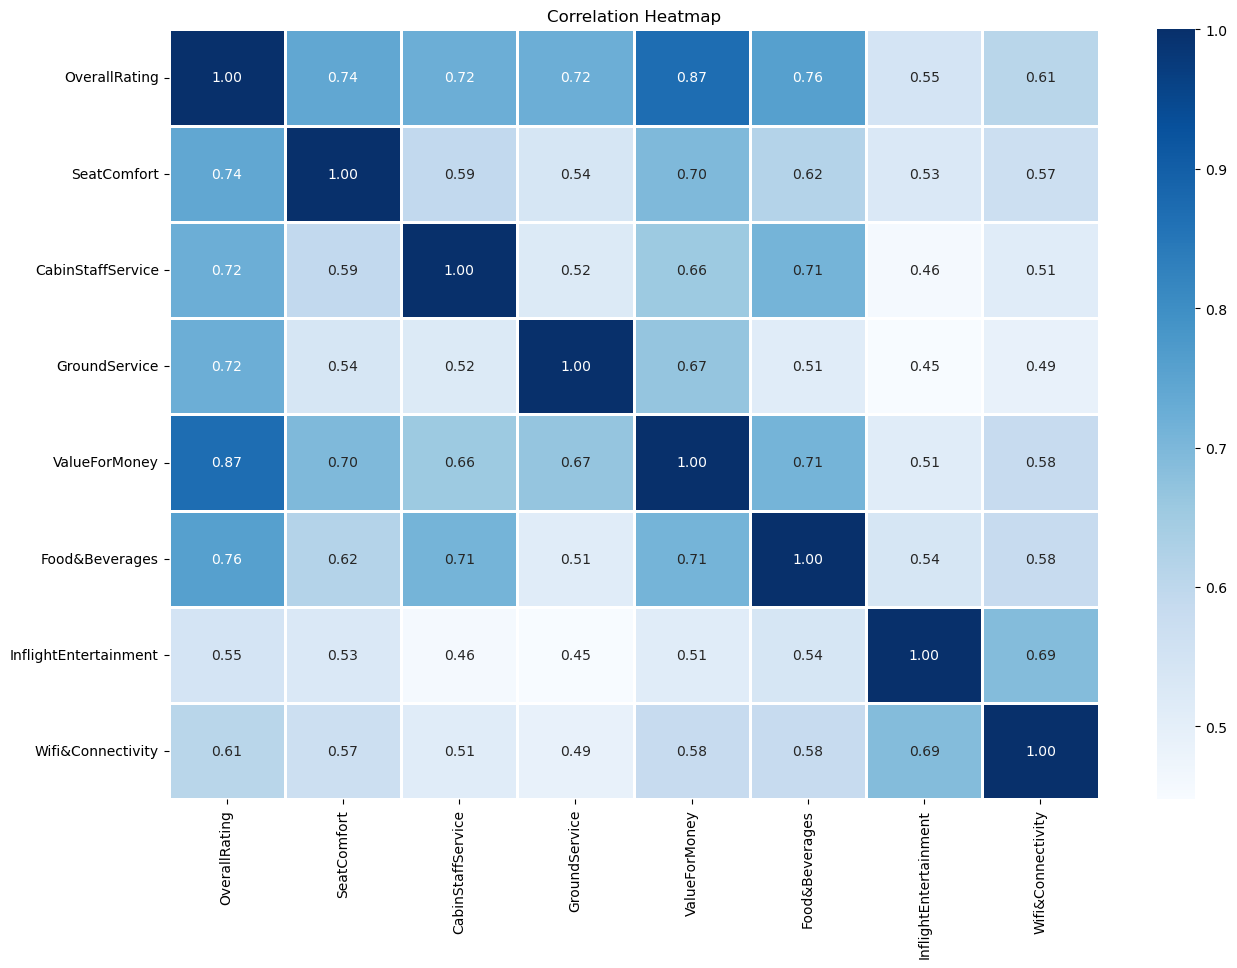

In [21]:
if 'Unnamed: 0' in df.columns:
    df = df.drop(columns=['Unnamed: 0'])
    
numerical_df = df.select_dtypes(include=['number'])

# Assuming 'df' is your DataFrame
plt.figure(figsize=(15, 10))

# Using Seaborn to create a heatmap
sns.heatmap(numerical_df.corr(), annot=True, fmt='.2f', cmap='Blues', linewidths=2)

plt.title('Correlation Heatmap')
plt.show()


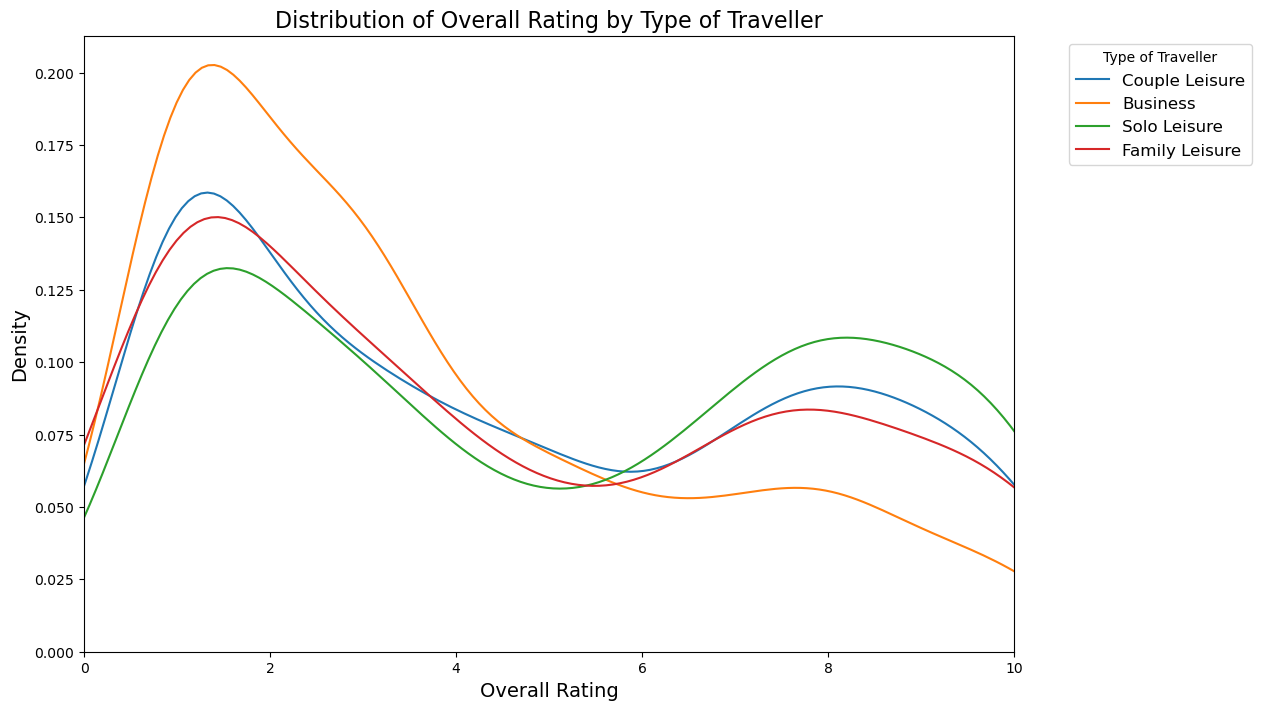

In [23]:
# Remove rows with null values in the 'TypeOfTraveller' column
#df = df.dropna(subset=['TypeOfTraveller'])

# Ensure 'TypeOfTraveller' is categorical
df['TypeOfTraveller'] = df['TypeOfTraveller'].astype('category')

# Set the color palette
sns.set_palette("tab10")

# Create the plot
plt.figure(figsize=(12, 8))

# Use sns.kdeplot to plot the KDE of OverallRating for each TypeOfTraveller
for traveller_type in df['TypeOfTraveller'].unique():
    sns.kdeplot(data=df[df['TypeOfTraveller'] == traveller_type], 
                x='OverallRating', 
                label=traveller_type)

# Add a title and labels
plt.title('Distribution of Overall Rating by Type of Traveller', fontsize=16)
plt.xlabel('Overall Rating', fontsize=14)
plt.ylabel('Density', fontsize=14)

# Set x-axis limits
plt.xlim(0, 10)

# Adjust the legend location
plt.legend(title='Type of Traveller', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=12)

# Show the plot
plt.show()


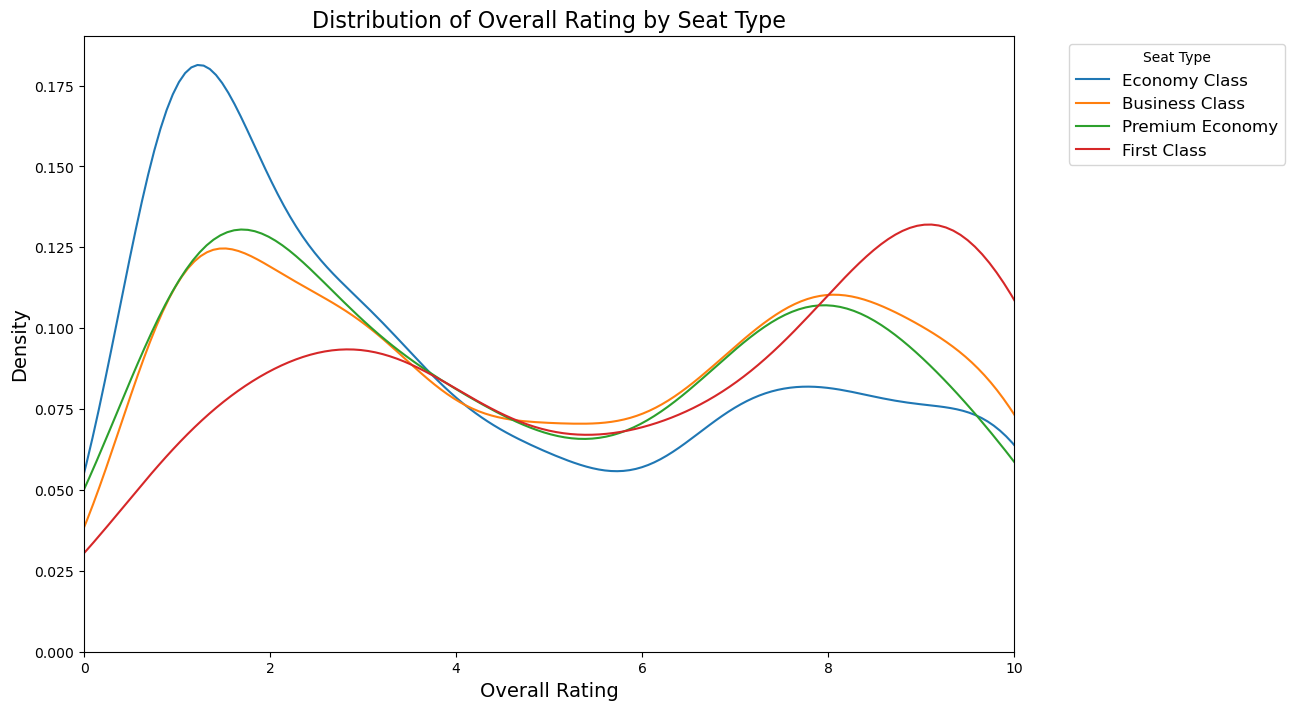

In [25]:
# Remove rows with null values in the 'TypeOfTraveller' column
#df = df.dropna(subset=['SeatType'])

# Ensure 'TypeOfTraveller' is categorical
df['SeatType'] = df['SeatType'].astype('category')

# Set the color palette
sns.set_palette("tab10")

# Create the plot
plt.figure(figsize=(12, 8))

# Use sns.kdeplot to plot the KDE of OverallRating for each TypeOfTraveller
for seat_type in df['SeatType'].unique():
    sns.kdeplot(data=df[df['SeatType'] == seat_type], 
                x='OverallRating', 
                label=seat_type)

# Add a title and labels
plt.title('Distribution of Overall Rating by Seat Type', fontsize=16)
plt.xlabel('Overall Rating', fontsize=14)
plt.ylabel('Density', fontsize=14)

# Set x-axis limits
plt.xlim(0, 10)

# Adjust the legend location
plt.legend(title='Seat Type', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=12)

# Show the plot
plt.show()


## Text Pre-Processing - Review Body

The following data preparation steps were performed:
1. Convert to lowercase
2. Remove punctuation (including hyphenated words and special characters)
3. Remove numbers
4. Tokenisation 
5. Filter stop words
6. Remove domain stop words
7. Remove words with less than 3 characters
8. Lemmatization
9. POS tagging and removal of specific Parts-of-Speech

In [28]:
df['ReviewBody']

0       4 Hours before takeoff we received a Mail stat...
1       I recently had a delay on British Airways from...
2       Boarded on time, but it took ages to get to th...
3       5 days before the flight, we were advised by B...
4       We traveled to Lisbon for our dream vacation, ...
                              ...                        
3695    Business LHR to BKK. 747-400. First try back w...
3696    This was a bmi Regional operated flight on a R...
3697    LHR to HAM. Purser addresses all club passenge...
3699    London City-New York JFK via Shannon on A318 b...
3700    SIN-LHR BA12 B747-436 First Class. Old aircraf...
Name: ReviewBody, Length: 3569, dtype: object

In [30]:
#Text pre-processing i.e. convert to lowercase, remove punctuation, remove numbers

def clean_text(text):
    text = text.lower()  # Convert to lowercase
    text = re.sub(r'[^\w\s]', '', text)  # Remove punctuation
    text = re.sub(r'\d+', '', text)  # Remove numbers
    return text

df['CleanText'] = df['ReviewBody'].apply(clean_text)


In [32]:
#check for special characters (including hyphens)

# create function to find special characters
def find_special_characters(text):
    return re.findall(r'[^\w\s]', text)

df['SpecialCharacters'] = df['CleanText'].apply(find_special_characters)

#create list of special characters and remove duplicates
all_special_characters = [char for sublist in df['SpecialCharacters'] for char in sublist]
unique_special_characters = list(set(all_special_characters))

unique_special_characters


[]

In [34]:
print(df['CleanText'])

0        hours before takeoff we received a mail stati...
1       i recently had a delay on british airways from...
2       boarded on time but it took ages to get to the...
3        days before the flight we were advised by ba ...
4       we traveled to lisbon for our dream vacation a...
                              ...                        
3695    business lhr to bkk  first try back with ba in...
3696    this was a bmi regional operated flight on a r...
3697    lhr to ham purser addresses all club passenger...
3699    london citynew york jfk via shannon on a but h...
3700    sinlhr ba b first class old aircraft  with sea...
Name: CleanText, Length: 3569, dtype: object


In [36]:
#tokenize review body column
from nltk.tokenize import word_tokenize

nltk.download('punkt')  # Download the tokenizer data

df['Tokens'] = df['CleanText'].apply(word_tokenize)


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\tangy\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [38]:
df['Tokens'].head(10)

0    [hours, before, takeoff, we, received, a, mail...
1    [i, recently, had, a, delay, on, british, airw...
2    [boarded, on, time, but, it, took, ages, to, g...
3    [days, before, the, flight, we, were, advised,...
4    [we, traveled, to, lisbon, for, our, dream, va...
5    [booked, a, flight, from, bucharest, to, manch...
6    [booked, online, months, ago, and, the, only, ...
7    [the, flight, was, on, time, the, crew, were, ...
8    [angry, disappointed, and, unsatisfied, my, ro...
9    [as, an, infrequent, flyer, british, airways, ...
Name: Tokens, dtype: object

In [40]:
#remove stopwords 
from nltk.corpus import stopwords

nltk.download('stopwords')  # Download the stopwords data

stop_words = set(stopwords.words('english'))

#check stop words
#print(stop_words)

custom_stopwords = {'airline', 'british', 'airway', 'airways', 'aircraft', 'airlines', 'plane',
                    'flight','flights','ba'}
stop_words.update(custom_stopwords)

df['Tokens'] = df['Tokens'].apply(lambda x: [word for word in x if word not in stop_words])

df['Tokens'].head(10)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\tangy\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


0    [hours, takeoff, received, mail, stating, cryp...
1    [recently, delay, bru, lhr, due, staff, shorta...
2    [boarded, time, took, ages, get, runway, due, ...
3    [days, advised, cancelled, asked, us, rebook, ...
4    [traveled, lisbon, dream, vacation, cruise, po...
5    [booked, bucharest, manchester, h, layover, he...
6    [booked, online, months, ago, hitch, replaceme...
7    [time, crew, polite, story, outward, find, eur...
8    [angry, disappointed, unsatisfied, route, lond...
9    [infrequent, flyer, always, first, choice, rea...
Name: Tokens, dtype: object

In [42]:
#remove words with less than n characters

#define n (number of characters)
n = 3

# create function to filter out words with fewer than n characters
def filter_char(tokens):
    return [word for word in tokens if len(word) >= n]

# apply the function to the 'Tokens' column
df['Tokens'] = df['Tokens'].apply(filter_char)
print(df['Tokens'].head(10))

0    [hours, takeoff, received, mail, stating, cryp...
1    [recently, delay, bru, lhr, due, staff, shorta...
2    [boarded, time, took, ages, get, runway, due, ...
3    [days, advised, cancelled, asked, rebook, hour...
4    [traveled, lisbon, dream, vacation, cruise, po...
5    [booked, bucharest, manchester, layover, heath...
6    [booked, online, months, ago, hitch, replaceme...
7    [time, crew, polite, story, outward, find, eur...
8    [angry, disappointed, unsatisfied, route, lond...
9    [infrequent, flyer, always, first, choice, rea...
Name: Tokens, dtype: object


In [44]:
#lemmatization
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
from nltk.tokenize import word_tokenize

# Download necessary NLTK data
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')

# Initialize lemmatizer
lemmatizer = WordNetLemmatizer()

# Function to map POS tags to WordNet POS tags
def get_wordnet_pos(treebank_tag):
    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN  # Default to noun

# Function to lemmatize tokens with POS tagging
def lemmatize_tokens(tokens):
    pos_tags = nltk.pos_tag(tokens)
    lemmatized_tokens = []
    for token, pos in pos_tags:
        wordnet_pos = get_wordnet_pos(pos)
        lemmatized_tokens.append(lemmatizer.lemmatize(token, wordnet_pos))
    return lemmatized_tokens

# Apply lemmatization
df['Tokens'] = df['Tokens'].apply(lemmatize_tokens)

df['Tokens'].head(10)



[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\tangy\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\tangy\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\tangy\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


0    [hour, takeoff, received, mail, state, cryptic...
1    [recently, delay, bru, lhr, due, staff, shorta...
2    [boarded, time, take, age, get, runway, due, c...
3    [day, advise, cancelled, ask, rebook, hour, ho...
4    [travel, lisbon, dream, vacation, cruise, port...
5    [book, bucharest, manchester, layover, heathro...
6    [book, online, month, ago, hitch, replacement,...
7    [time, crew, polite, story, outward, find, eur...
8    [angry, disappoint, unsatisfied, route, london...
9    [infrequent, flyer, always, first, choice, rea...
Name: Tokens, dtype: object

In [46]:
# POS tagging and removal of specific Parts-of-Speech 

# define parts of speech to be removed
filter_pos = {'CC', 'IN', 'DT', 'PRP', 'AUX', 'UH'}

# create function to filter out specific POS tags
def filter_pos_tags(tokens):
    pos_tags = nltk.pos_tag(tokens)
    filtered_tokens = [word for word, pos in pos_tags if pos not in filter_pos]
    return filtered_tokens

df['Tokens'] = df['Tokens'].apply(filter_pos_tags)

df['Tokens'].head(10)

0    [hour, takeoff, received, mail, state, cryptic...
1    [recently, delay, bru, lhr, due, staff, shorta...
2    [boarded, time, take, age, get, runway, due, c...
3    [day, advise, cancelled, ask, rebook, hour, ho...
4    [travel, lisbon, dream, vacation, cruise, port...
5    [book, bucharest, manchester, layover, heathro...
6    [book, online, month, ago, hitch, replacement,...
7    [time, crew, polite, story, outward, europe, g...
8    [angry, disappoint, unsatisfied, route, london...
9    [infrequent, flyer, always, first, choice, rea...
Name: Tokens, dtype: object

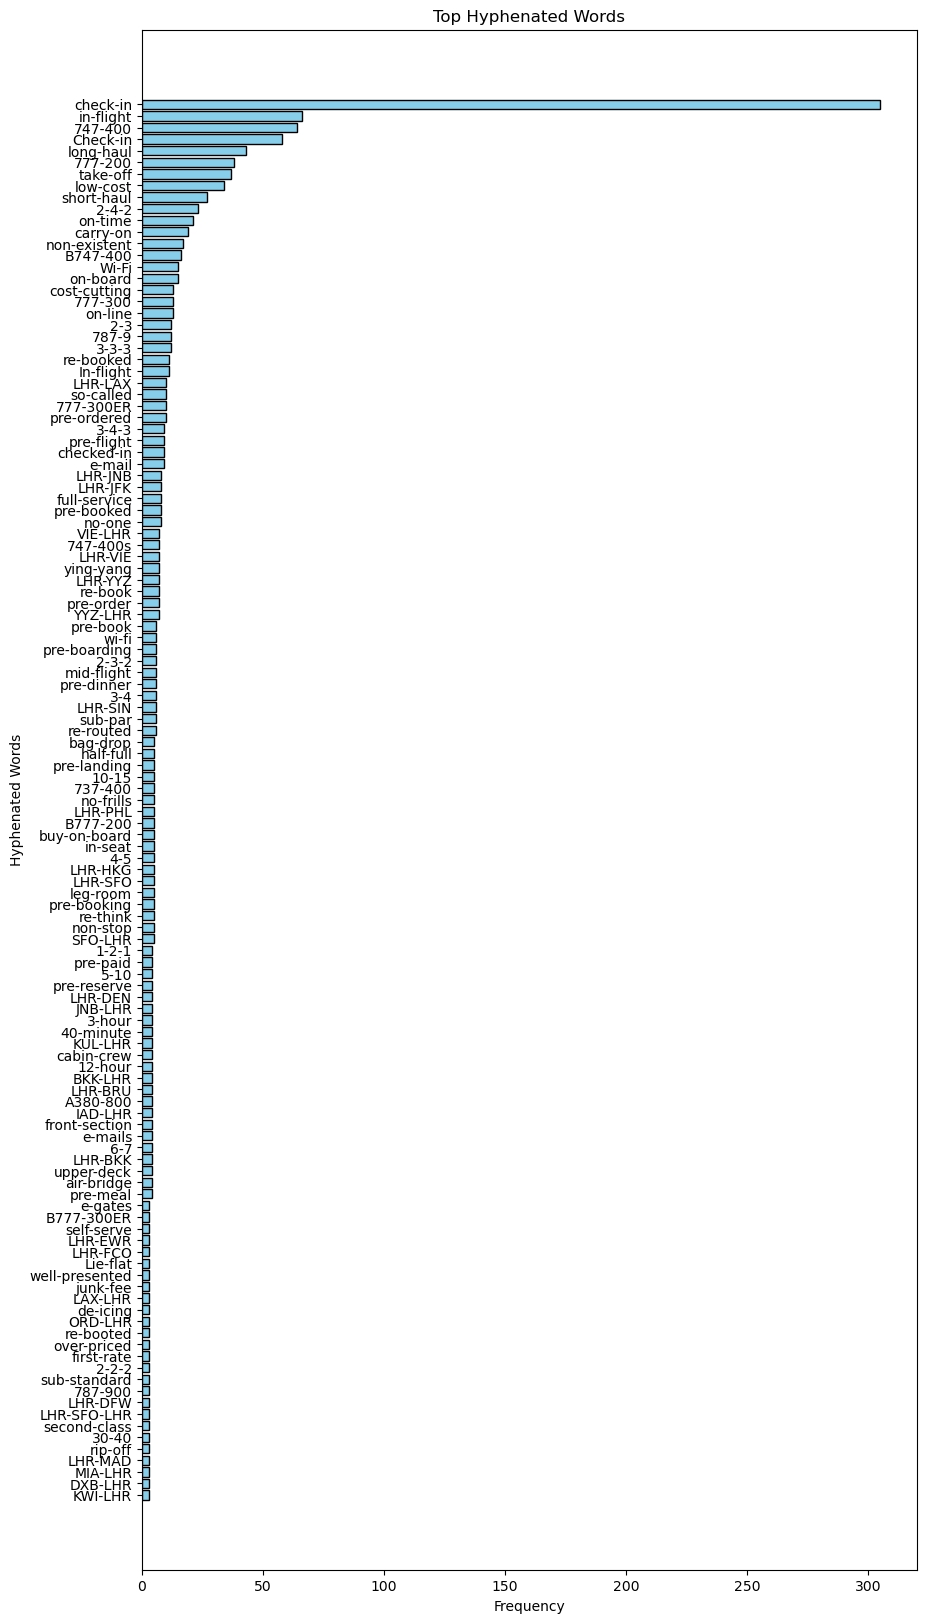

In [48]:
#extract hyphenated words in review body 
from collections import Counter

# create function to find hyphenated words
def find_hyphenated_words(text):
    return re.findall(r'\b\w+(?:-\w+)+\b', text)

# apply the function
df['HyphenatedWords'] = df['ReviewBody'].apply(find_hyphenated_words)

#create list of hyphenated words and remove duplicates
all_hyphenated_words = [word for sublist in df['HyphenatedWords'] for word in sublist]
unique_hyphenated_words = list(set(all_hyphenated_words))

unique_hyphenated_words

# count the frequency of each hyphenated word
word_freq = Counter(all_hyphenated_words)

# convert frequency dictionary to DataFrame
freq_df = pd.DataFrame(word_freq.items(), columns=['Word', 'Frequency']).sort_values(by='Frequency', ascending=False)

# determine the number of top words to include
m = int(len(freq_df) * 0.10)  # Top 10%
filtered_df = freq_df.head(m)

# plot the bar chart for the top 50 hyphenated words
plt.figure(figsize=(10, 20))
plt.barh(filtered_df['Word'], filtered_df['Frequency'], color='skyblue', edgecolor='black')
plt.xlabel('Frequency')
plt.ylabel('Hyphenated Words')
plt.title(f'Top Hyphenated Words')
plt.gca().invert_yaxis()  # Invert y-axis to show highest frequencies on top
plt.show()

#Hyphenated words seem to contribute to the understanding of topics of the reviews, 
#i.e. "check-in", "long-haul", "pre-boarding", and should be retained in the dataset.

#May have to consider between retaining hyphenated words or using n-grams analysis to improve topic modelling

In [50]:
#generate sentiments using textblob
from textblob import TextBlob

def get_sentiment(text):
    analysis = TextBlob(text)
    return analysis.sentiment.polarity  # Returns a value between -1 (negative) and 1 (positive)

df['Sentiment'] = df['CleanText'].apply(get_sentiment)

df.head(5)

,OverallRating,ReviewHeader,Name,Datetime,VerifiedReview,ReviewBody,TypeOfTraveller,SeatType,Route,DateFlown,...,Recommended,Aircraft,Food&Beverages,InflightEntertainment,Wifi&Connectivity,CleanText,SpecialCharacters,Tokens,HyphenatedWords,Sentiment
0,1.0,"""Service level far worse then Ryanair""",L Keele,2023-11-19,True,4 Hours before takeoff we received a Mail stat...,Couple Leisure,Economy Class,London to Stuttgart,NaT,...,no,NaN,NaN,NaN,NaN,hours before takeoff we received a mail stati...,[],"[hour, takeoff, received, mail, state, cryptic...",[],-0.045588
1,3.0,"""do not upgrade members based on status""",Austin Jones,2023-11-19,True,I recently had a delay on British Airways from...,Business,Economy Class,Brussels to London,NaT,...,no,A320,1.0,2.0,2.0,i recently had a delay on british airways from...,[],"[recently, delay, bru, lhr, due, staff, shorta...",[world-class],0.006944
2,8.0,"""Flight was smooth and quick""",M A Collie,2023-11-16,False,"Boarded on time, but it took ages to get to th...",Couple Leisure,Business Class,London Heathrow to Dublin,NaT,...,yes,A320,4.0,NaN,NaN,boarded on time but it took ages to get to the...,[],"[boarded, time, take, age, get, runway, due, c...",[],0.128030
3,1.0,"""Absolutely hopeless airline""",Nigel Dean,2023-11-16,True,"5 days before the flight, we were advised by B...",Couple Leisure,Economy Class,London to Dublin,NaT,...,no,NaN,NaN,NaN,NaN,days before the flight we were advised by ba ...,[],"[day, advise, cancelled, ask, rebook, hour, ho...",[],0.113889
4,1.0,"""Customer Service is non existent""",Gaylynne Simpson,2023-11-14,False,"We traveled to Lisbon for our dream vacation, ...",Couple Leisure,Economy Class,London to Lisbon,NaT,...,no,NaN,1.0,1.0,1.0,we traveled to lisbon for our dream vacation a...,[],"[travel, lisbon, dream, vacation, cruise, port...",[],-0.073958


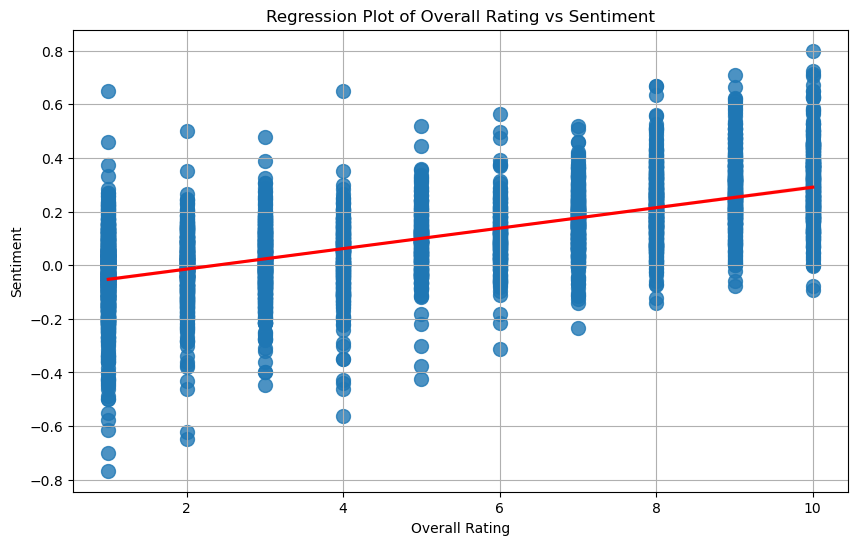

In [52]:
# Regression plot
plt.figure(figsize=(10, 6))
sns.regplot(x='OverallRating', y='Sentiment', data=df, scatter_kws={'s':100}, line_kws={'color':'red'})

plt.title('Regression Plot of Overall Rating vs Sentiment')
plt.xlabel('Overall Rating')
plt.ylabel('Sentiment')
plt.grid(True)
plt.show()


In [54]:
#generate word cloud of TF-IDF terms
from sklearn.feature_extraction.text import TfidfVectorizer

df['CleanText'] = df['Tokens'].apply(lambda x: ' '.join(x))

# Create a TfidfVectorizer instance
tfidf_vectorizer = TfidfVectorizer()

# Transform the 'CleanText' column
X_tfidf = tfidf_vectorizer.fit_transform(df['CleanText'])

# Get feature names
feature_names_tfidf = tfidf_vectorizer.get_feature_names_out()

# Print the TF-IDF matrix and feature names
print(X_tfidf.toarray())
print(feature_names_tfidf)


[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
['aacx' 'aback' 'abandon' ... 'zürich' 'álex' 'über']


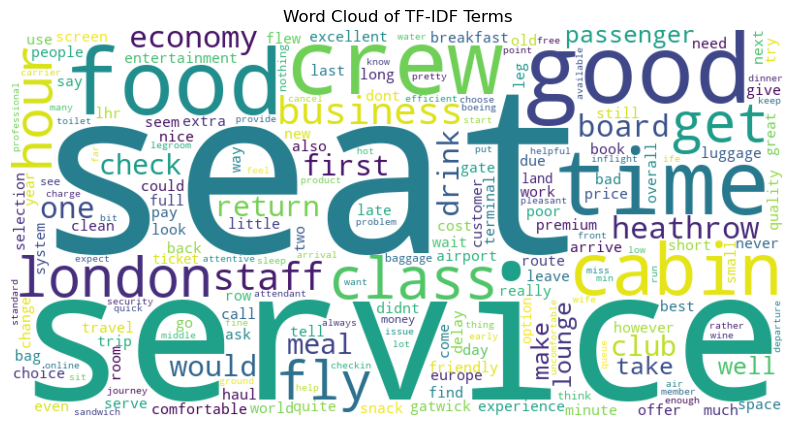

In [56]:
from wordcloud import WordCloud

# Summing up the tf-idf values for each term across all documents
sum_tfidf = X_tfidf.sum(axis=0)
words_freq = {word: sum_tfidf[0, idx] for word, idx in tfidf_vectorizer.vocabulary_.items()}

# Creating a word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(words_freq)

# Plotting the word cloud
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of TF-IDF Terms')
plt.show()


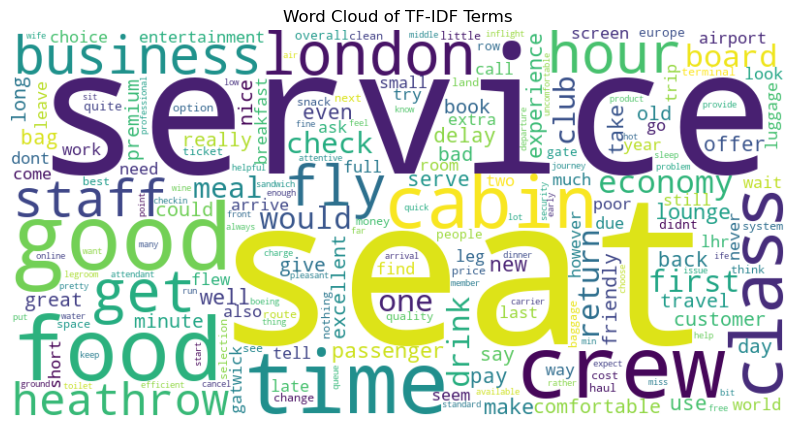

In [58]:
from wordcloud import WordCloud

# Summing up the tf-idf values for each term across all documents
sum_tfidf = X_tfidf.sum(axis=0)
words_freq = {word: sum_tfidf[0, idx] for word, idx in tfidf_vectorizer.vocabulary_.items()}

# Creating a word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(words_freq)

# Plotting the word cloud
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of TF-IDF Terms')
plt.show()


In [64]:
import pandas as pd
from gensim import corpora
from gensim.models import LdaModel

# Step 1: Filter the DataFrame for reviews with OverallRating >= 7
filtered_df = df[df['OverallRating'] >= 7]
print(f"Filtered dataset contains {len(filtered_df)} reviews.")

# Step 2: Generate Tokens, Dictionary, and Corpus from the Filtered Data
texts = filtered_df['Tokens'].tolist()
dictionary = corpora.Dictionary(texts)
corpus = [dictionary.doc2bow(text) for text in texts]

# Create LDA model
lda_model = LdaModel(corpus=corpus,
                     id2word=dictionary,
                     num_topics=3,
                     random_state=42,
                     passes=10,
                     alpha='auto',
                     per_word_topics=True)

# Step 3: Assign topics to documents
def get_dominant_topic(ldamodel, corpus):
    topics = []
    for doc in corpus:
        topic_probs = ldamodel[doc]
        dominant_topic = max(topic_probs[0], key=lambda x: x[1])[0]
        topics.append(dominant_topic)
    return topics

# Get the dominant topic for each document
filtered_df['DominantTopic'] = get_dominant_topic(lda_model, corpus)

# Display the DataFrame with the new column
print(filtered_df.head())

# Optionally save the updated DataFrame
filtered_df.to_csv('filtered_reviews_with_topics.csv', index=False)


Filtered dataset contains 1321 reviews.
    OverallRating                     ReviewHeader             Name  \
2             8.0    "Flight was smooth and quick"       M A Collie   
6             8.0    "sufficient leg and arm room"  Graeme Boothman   
7             7.0               “crew were polite”          R Vines   
10            8.0  "A totally unremarkable flight"         M Collie   
13            8.0       "One of my better flights"       M Davidson   

     Datetime  VerifiedReview  \
2  2023-11-16           False   
6  2023-11-08            True   
7  2023-11-07            True   
10 2023-11-04           False   
13 2023-10-24            True   

                                           ReviewBody TypeOfTraveller  \
2   Boarded on time, but it took ages to get to th...  Couple Leisure   
6   Booked online months ago and the only hitch wa...  Couple Leisure   
7   The flight was on time. The crew were polite. ...    Solo Leisure   
10  A totally unremarkable flight, on time

In [60]:
# Assuming your DataFrame is named 'df'
filtered_df = df[df['OverallRating'] >= 7]


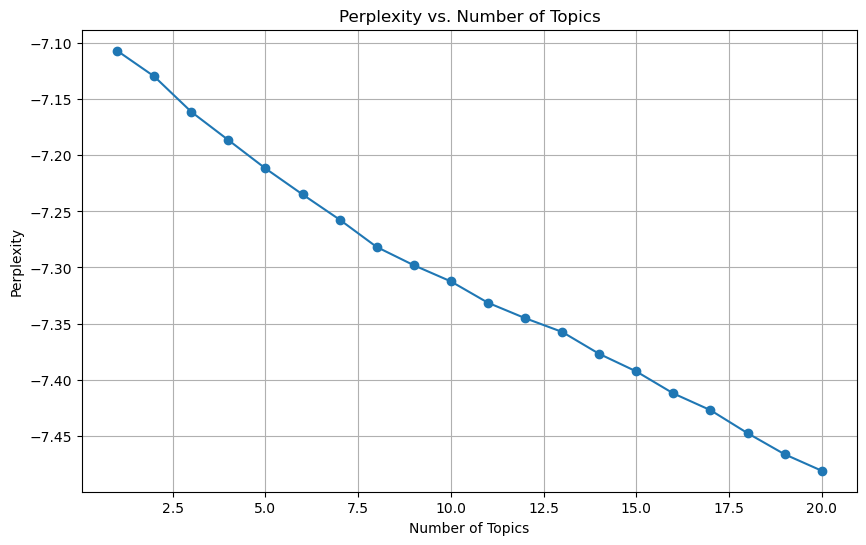

In [103]:
import pandas as pd
import matplotlib.pyplot as plt
from gensim import corpora
from gensim.models import LdaModel

# Filter the DataFrame for reviews with OverallRating >= 7
filtered_df = df[df['OverallRating'] >= 7]
texts = filtered_df['Tokens'].tolist()
dictionary = corpora.Dictionary(texts)
corpus = [dictionary.doc2bow(text) for text in texts]

# Define range of topics
topic_range = range(1, 21)
perplexity_values = []

# Train LDA models and compute perplexity
for num_topics in topic_range:
    lda_model = LdaModel(corpus=corpus,
                         id2word=dictionary,
                         num_topics=num_topics,
                         random_state=42,
                         passes=10,
                         alpha='auto',
                         per_word_topics=True)
    
    perplexity = lda_model.log_perplexity(corpus)
    perplexity_values.append(perplexity)

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(topic_range, perplexity_values, marker='o')
plt.title('Perplexity vs. Number of Topics')
plt.xlabel('Number of Topics')
plt.ylabel('Perplexity')
plt.grid(True)
plt.show()


In [66]:
# Extract the 'Tokens' column as a list of lists
texts = filtered_df['Tokens'].tolist()

# Create a dictionary and corpus from the filtered data
dictionary = corpora.Dictionary(texts)
corpus = [dictionary.doc2bow(text) for text in texts]

In [68]:
# Set parameters
num_topics = 3  # Adjust as needed
random_state = 42

# Build the LDA model
lda_model = LdaModel(corpus=corpus,
                     id2word=dictionary,
                     num_topics=num_topics,
                     random_state=random_state,
                     passes=10,
                     alpha='auto',
                     per_word_topics=True)


In [70]:
# Print the topics
for idx, topic in lda_model.print_topics(-1):
    print(f"Topic {idx}: {topic}")



Topic 0: 0.012*"heathrow" + 0.009*"crew" + 0.008*"seat" + 0.008*"cabin" + 0.008*"time" + 0.008*"board" + 0.007*"service" + 0.007*"staff" + 0.007*"food" + 0.007*"first"
Topic 1: 0.021*"seat" + 0.018*"good" + 0.014*"crew" + 0.013*"food" + 0.012*"service" + 0.012*"time" + 0.011*"cabin" + 0.008*"london" + 0.007*"economy" + 0.007*"well"
Topic 2: 0.017*"good" + 0.013*"seat" + 0.010*"service" + 0.008*"staff" + 0.008*"get" + 0.008*"time" + 0.007*"lounge" + 0.007*"crew" + 0.006*"food" + 0.006*"london"


In [76]:
# Perplexity on the training set
perplexity = lda_model.log_perplexity(corpus)
print(f'Perplexity: {perplexity}')

Perplexity: -7.161226768180681


In [74]:
# Assuming lda_model, corpus, and dictionary are already defined

pyLDAvis.enable_notebook()  # Use this if you're working in a Jupyter notebook
vis = pyLDAvis.gensim_models.prepare(lda_model, corpus, dictionary)

# For Jupyter notebooks
vis


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1     -0.023888  0.036673       1        1  67.020654
2     -0.025478 -0.035894       2        1  19.054227
0      0.049366 -0.000779       3        1  13.925120, topic_info=            Term         Freq        Total Category  logprob  loglift
295     heathrow   512.000000   512.000000  Default  30.0000  30.0000
89         staff   445.000000   445.000000  Default  29.0000  29.0000
10          good  1362.000000  1362.000000  Default  28.0000  28.0000
9            get   461.000000   461.000000  Default  27.0000  27.0000
35         board   517.000000   517.000000  Default  26.0000  26.0000
..           ...          ...          ...      ...      ...      ...
290   experience    45.037100   356.021408   Topic3  -5.5576  -0.0960
222     business    43.858198   348.225669   Topic3  -5.5842  -0.1004
179       return    41.954135   461.457508   Topic3  -5.6286  -0.4263
25          take    40.061980   328.597242   Topic3  -5.6747  -0.1329
120  comfortable    40.988543   454.853686   Topic3  -5.6518  -0.4352

[277 rows x 6 columns], token_table=      Topic      Freq       Term
term                            
2421      2  0.900662        abu
1995      2  0.758440  accompany
1995      3  0.151688  accompany
2469      1  0.958856     airbus
2469      3  0.039952     airbus
...     ...       ...        ...
148       3  0.100801      would
2107      1  0.947495       york
2107      3  0.057424       york
2744      1  0.139569     zurich
2744      3  0.837413     zurich

[419 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 3, 1])

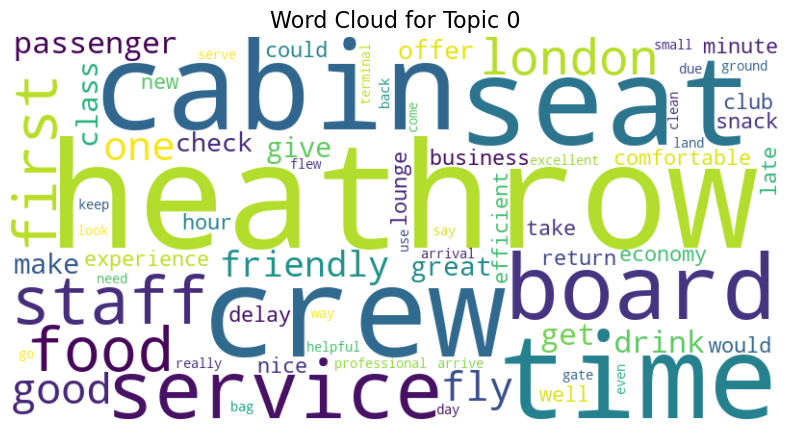

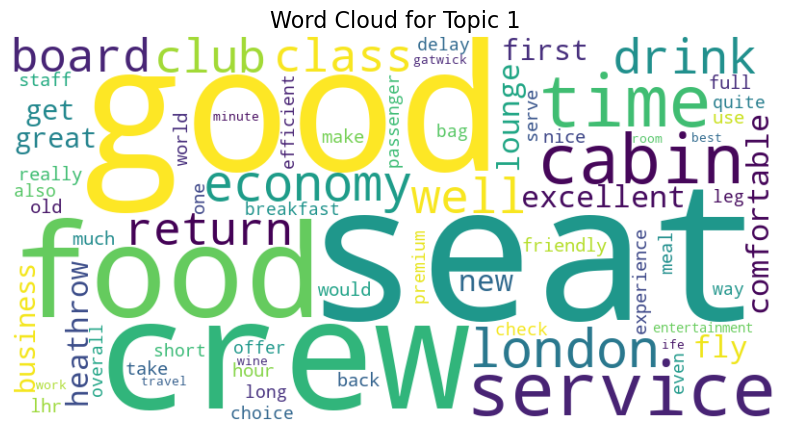

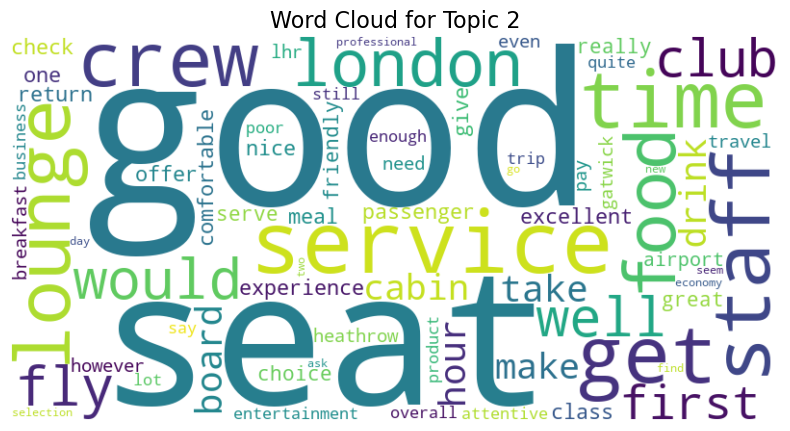

In [78]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Create a function to generate word cloud for a given topic
def plot_word_cloud(lda_model, topic_id, word_count=10):
    # Get the top words and their weights for the topic
    topic_words = dict(lda_model.show_topic(topic_id, word_count))
    
    # Generate the word cloud
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(topic_words)
    
    # Plot the word cloud
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.title(f"Word Cloud for Topic {topic_id}", fontsize=16)
    plt.show()

# Generate word clouds for the first 3 topics
for i in range(3):
    plot_word_cloud(lda_model, topic_id=i, word_count=70)


In [89]:
from gensim.models.coherencemodel import CoherenceModel

# For LDA model
coherence_lda = CoherenceModel(model=lda_model, texts=texts, dictionary=dictionary, coherence='c_v')
coherence_lda_score = coherence_lda.get_coherence()

In [91]:
print(f"LDA Coherence Score: {coherence_lda_score}")

LDA Coherence Score: nan


In [97]:
# Check the number of documents
print(f"Number of documents: {len(texts)}")

# Check if the dictionary is built correctly
print(f"Number of tokens in the dictionary: {len(dictionary)}")

# Check LDA topics
lda_topics = lda_model.show_topics(formatted=False)
for topic in lda_topics:
    print(f"Topic {topic[0]}: {topic[1]}")


Number of documents: 3569
Number of tokens in the dictionary: 6220
Topic 0: [('heathrow', 0.011891905), ('crew', 0.008798625), ('seat', 0.008267604), ('cabin', 0.008010477), ('time', 0.00782125), ('board', 0.007773653), ('service', 0.0074838004), ('staff', 0.0073661217), ('food', 0.006951151), ('first', 0.006839383)]
Topic 1: [('seat', 0.021144189), ('good', 0.018106986), ('crew', 0.013789854), ('food', 0.012938216), ('service', 0.0124430545), ('time', 0.011893402), ('cabin', 0.010735086), ('london', 0.008257876), ('economy', 0.0073785605), ('well', 0.0067670085)]
Topic 2: [('good', 0.016755683), ('seat', 0.012975577), ('service', 0.009577122), ('staff', 0.007883748), ('get', 0.007839197), ('time', 0.007836717), ('lounge', 0.007319724), ('crew', 0.00711243), ('food', 0.0061481525), ('london', 0.005739347)]


In [101]:
from gensim.corpora import Dictionary
from gensim.models import CoherenceModel

# Tokenized texts should be the same used for LDA
texts = [doc.split() for doc in df['CleanText']]

# Rebuild the dictionary to ensure consistency
dictionary = Dictionary(texts)

# Filter extremes (this might have been done before LDA, so repeat it here)
dictionary.filter_extremes(no_below=5, no_above=0.5)

# Ensure texts contain only words in the dictionary
texts = [[word for word in text if word in dictionary.token2id] for text in texts]

# Create corpus
corpus = [dictionary.doc2bow(text) for text in texts]

# Compute the coherence score
coherence_lda = CoherenceModel(model=lda_model, texts=texts, dictionary=dictionary, coherence='c_v')
coherence_lda_score = coherence_lda.get_coherence()

print(f"LDA Coherence Score: {coherence_lda_score}")


LDA Coherence Score: 0.2323480651913843
